In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
def OneHot(df, col):
    uniques = df[col].unique()
    if len(uniques)==2:
        val = df.at[0, col]
        df[col] = df[col].apply(lambda x : int(x==val))
        return df
    else:
        new_cols = pd.DataFrame({f"{col}{i}" : (df[col]==val).astype(int) for i, val in enumerate(uniques)})
        return pd.concat([df, new_cols], axis=1)

In [4]:
data = data.drop(["Id", "MSSubClass", "LotFrontage", "Street", "Alley", "Utilities", "LandSlope", "LowQualFinSF", "BsmtHalfBath", "PoolArea", "PoolQC", "MiscVal", "MoSold", "MiscFeature"], axis=1)

for col in data.loc[:2, (data.dtypes!=object) & (data.isnull().sum()>0)].columns:
    data[col] = data[col].fillna(data[col].mean())
data.loc[:, data.dtypes==float] = data.loc[:, data.dtypes==float].astype(int)
data = data.fillna("Unknown")

cols = data.loc[:, data.dtypes==object].columns
for col in cols:
    data = OneHot(data, col)
data = data.drop(data.loc[:, data.dtypes==object].columns, axis=1)

In [5]:
test = test.drop(["Id", "MSSubClass", "LotFrontage", "Street", "Alley", "Utilities", "LandSlope", "LowQualFinSF", "BsmtHalfBath", "PoolArea", "PoolQC", "MiscVal", "MoSold", "MiscFeature"], axis=1)

for col in test.loc[:2, (test.dtypes!=object) & (test.isnull().sum()>0)].columns:
    test[col] = test[col].fillna(test[col].mean())
test.loc[:, test.dtypes==float] = test.loc[:, test.dtypes==float].astype(int)
test = test.fillna("Unknown")

cols = test.loc[:, test.dtypes==object].columns
for col in cols:
    test = OneHot(test, col)
test = test.drop(test.loc[:, test.dtypes==object].columns, axis=1)

In [6]:
split = int(0.8*data.shape[0])

X = data.drop("SalePrice", axis=1)
y = data.SalePrice

X_train, X_test = X.loc[:split], X.loc[split+1:]
y_train, y_test = y.loc[:split], y.loc[split+1:]

In [69]:
class LinearRegression:
    """ Linear Regression class
    Parameters : 
        a = array of coefficients
        b = bias
        lr = learning rate
        n = no. data (rows)
        m = no. features (columns)
        
    """ 
    
    def __init__(self, m, lr=0.0000000001):
        self.lr = lr
        self.a = np.ones(m)
        self.b = 1

    def adjust(self, x=1.01):
        self.lr /= x

    def train(self, /, X_train, y_train, X_test, y_test, *, epochs=10, verbose=1):
        ba, bb = self.a.copy(), self.b
        mn_err = np.inf
        for epoch in range(epochs):
            self.fit(X_train, y_train)
            error = MSE(y_test, self.predict(X_test))
            if error < mn_err:
                mn_err = error
                ba = self.a.copy()
                bb = self.b
            else:
                self.adjust()
            if (verbose) and (epoch%5==0):
                print(f"Epoch : {epoch}, MSE = {error}")
        self.a = ba.copy()
        self.b = bb
        print(f"least error : {mn_err}")
    
    def fit(self, X, y):
        for i, row in X.iterrows():
            error = self.b + np.dot(row.to_numpy(), self.a) - y.iloc[i] # h(x) - y[i]
            for j, col in enumerate(row):
                self.a[j] -= self.lr * error * col
            self.b -= self.lr * error          

    def predict(self, X):
        return np.array([np.dot(row, self.a)+self.b for i, row in X.iterrows()])

def MSE(act, pred):
    if isinstance(act, np.ndarray)==False:
        act = act.to_numpy()
    if isinstance(pred, np.ndarray)==False:
        pred = pred.to_numpy()
    res = 0
    for i, j in zip(act, pred):
        res += (i-j)**2
    return res/len(act)

In [70]:
model = LinearRegression(X_train.shape[1])
model.train(X_train, y_train, X_test, y_test, epochs=25) 
res = model.predict(X_test)

Epoch : 0, MSE = 5234527763.98555
Epoch : 5, MSE = 4087004211.3946395
Epoch : 10, MSE = 3709344010.9601912
Epoch : 15, MSE = 3516342939.627065
Epoch : 20, MSE = 3435852618.6753316
least error : 3420611449.8861666


In [71]:
from sklearn.linear_model import LinearRegression as LR

m2 = LR()
m2.fit(X_train, y_train)
p2 = m2.predict(X_test)


benchmark = MSE(y_test, p2)

In [72]:
err = MSE(y_test, res)
print(f"\nError 1 is higher than Error 2 by : {round(err / benchmark, 3) * 100}%")


Error 1 is higher than Error 2 by : 136.60000000000002%


In [23]:
import matplotlib.pyplot as plt

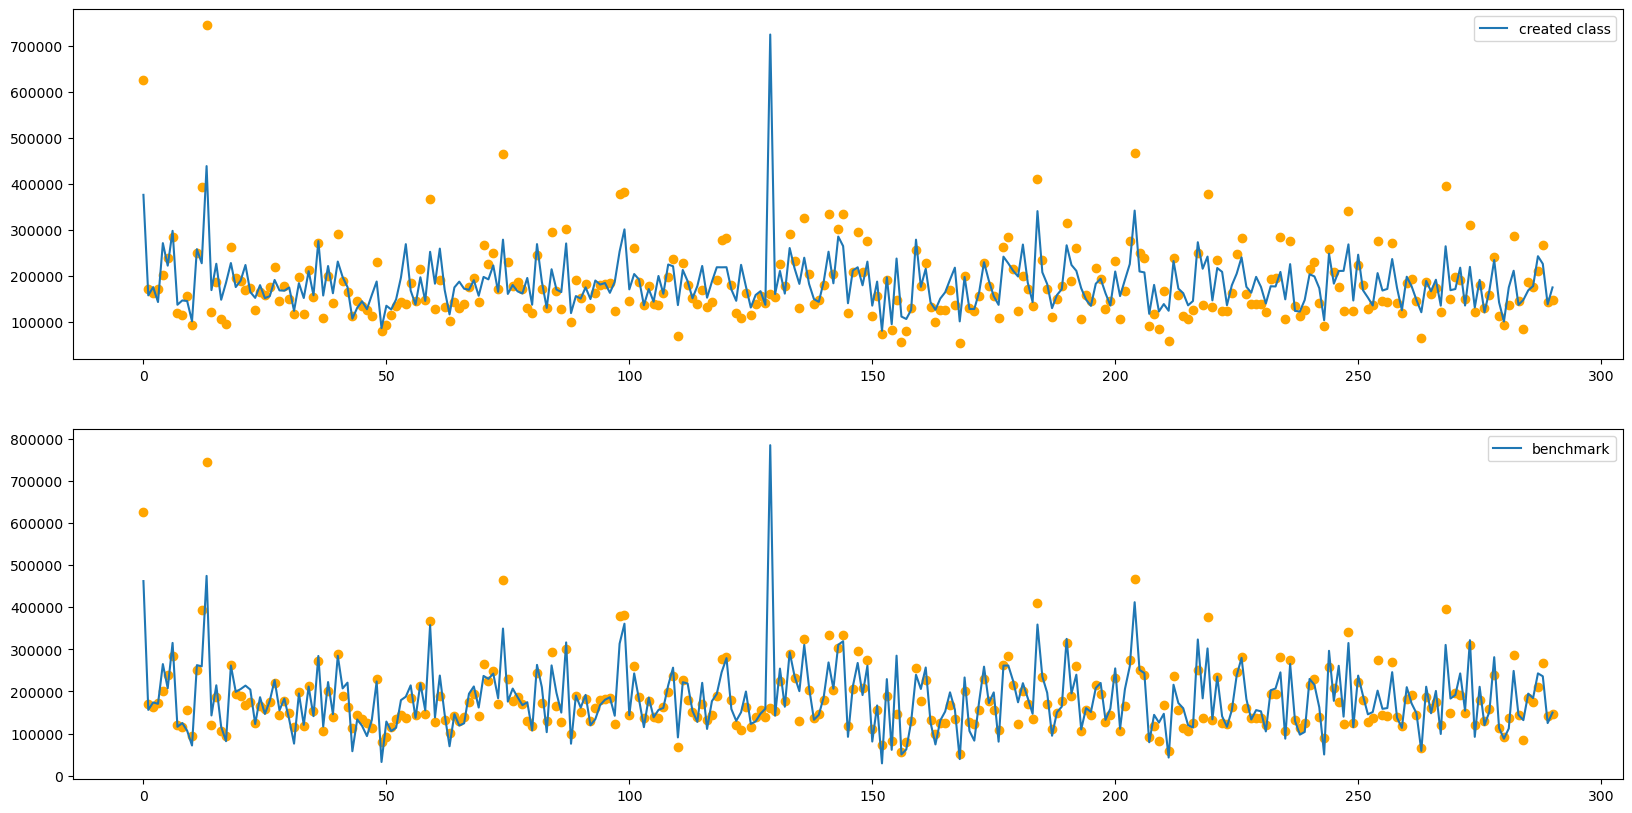

In [24]:
fig, ax = plt.subplots(2, figsize=(20, 10))
ax[0].plot(res, label="created class")
ax[0].scatter(np.arange(len(y_test)), y_test, color="orange")
ax[1].plot(p2, label="benchmark")
ax[1].scatter(np.arange(len(y_test)), y_test, color="orange")
ax[0].legend()
ax[1].legend()

plt.show()